<a href="https://colab.research.google.com/github/saspav/Introduction_Competitive_Data_Science/blob/main/task_12_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практический урок по блендингу и стекингу

**Задача:** Обучить модели для блендинга и стекинга и выбрать из них лучшие.

**Датасеты:**
* [quickstart_train.csv](https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv)
* [quickstart_test.csv](https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv)

**Регрессионный таргет:** столбец `target_reg` , метрика `RMSE`.

**Для блендинга и стекинга выбрать 3 модели:**

* Любые 2 бустинга на ваш выбор.
* Любую другую модель (не бустинг).
* Для стекинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и т. п.).

In [11]:
import os
import warnings

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

### Установка доп.модулей

In [34]:
!pip install scikit_learn==1.3.2 -q
!pip install catboost==1.2.7 -q
!pip install featuretools==1.31.0 -q
!pip install optuna==4.1.0 -q
!pip install optuna-integration==4.1.0 -q

# Установка pystacknet
!git clone https://gitlab.com/YannBerthelot/kaggle_pystacknet.git -q
!pip install "kaggle_pystacknet/pystacknet" -q

# Скачиваем дополнительные модули из репо
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/df_addons.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/print_time.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/data_process.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/set_all_seeds.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/custom_stacking.py > /dev/null 2>&1

fatal: destination path 'kaggle_pystacknet' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


### Импорт модулей

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns

import optuna
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostRegressor, Pool
from optuna.integration import LightGBMPruningCallback
from lightgbm import LGBMRegressor, Dataset
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBRegressor, DMatrix
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

from data_process import (RANDOM_SEED, MODELS_LOGS_REG, PREDICTIONS_DIR, MODEL_PATH, get_max_num,
                          DataTransform, set_all_seeds, make_predict_reg, add_info_to_log, merge_submits)
from print_time import print_time, print_msg

set_all_seeds(seed=RANDOM_SEED)

## Загрузка данных

In [14]:
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data'
train_path = url + '/quickstart_train.csv'
test_path = url + '/quickstart_test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

### EDA на минималках

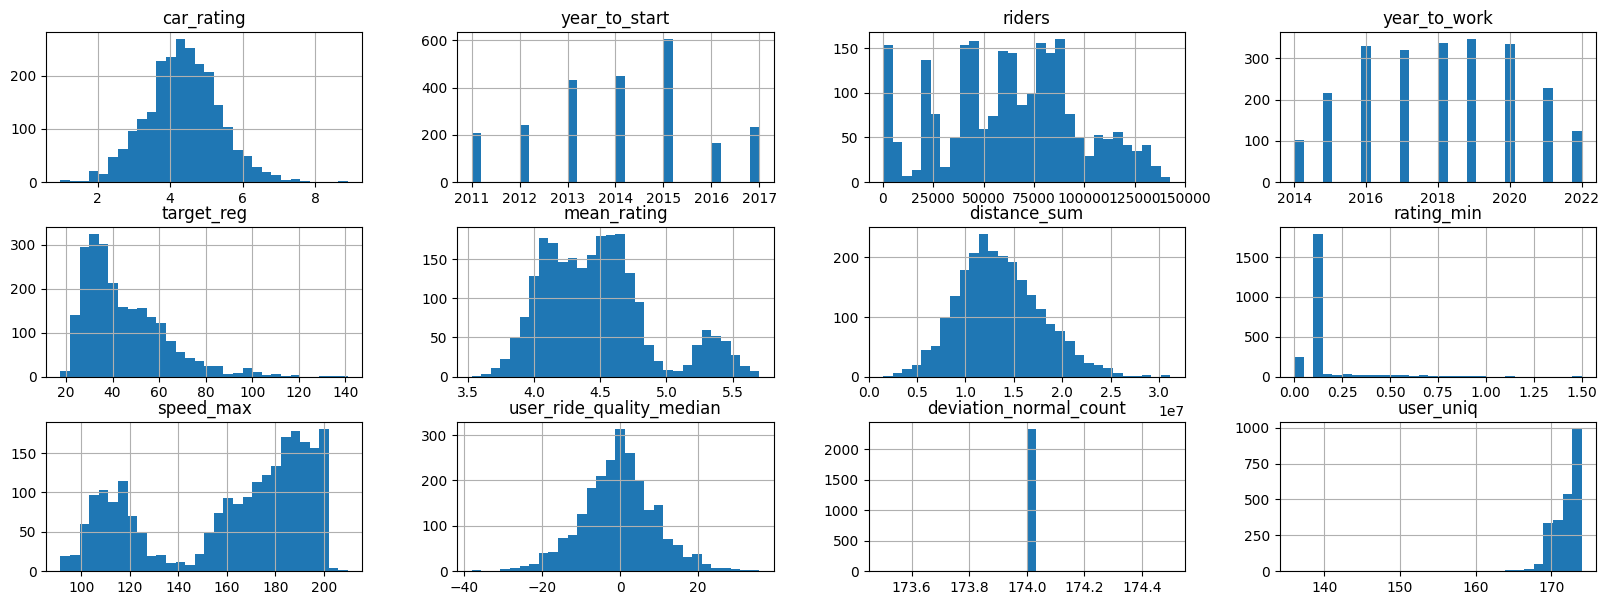

In [15]:
train.hist(figsize = (20, 7), layout = (-1, 4), bins=30);

In [16]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2.337000e+03,2337.000000,2337.000000,2337.000000,2337.0,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.947381,4.478831,1.356912e+07,0.138870,160.984884,-0.329339,174.0,171.624305
std,0.996954,1.685852,33755.012096,2.159484,17.647533,0.418588,4.253209e+06,0.163978,33.211161,9.581800,0.0,3.158088
min,0.980000,2011.000000,23.000000,2014.000000,17.640000,3.529885,1.478866e+06,0.000000,91.423508,-38.116345,174.0,136.000000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.570000,4.155747,1.058758e+07,0.100000,123.609208,-6.141569,174.0,171.000000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.010000,4.442989,1.321852e+07,0.100000,172.435742,-0.195860,174.0,172.000000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.720000,4.675345,1.631788e+07,0.100000,188.597411,5.370422,174.0,173.000000
max,8.900000,2017.000000,142862.000000,2022.000000,141.130000,5.700747,3.119785e+07,1.500000,209.982840,35.770493,174.0,174.000000


In [17]:
for col in train.columns:
    print(f'Признак: {col} --> Уникальных значений: {train[col].nunique()}')

Признак: car_id --> Уникальных значений: 2337
Признак: model --> Уникальных значений: 26
Признак: car_type --> Уникальных значений: 4
Признак: fuel_type --> Уникальных значений: 2
Признак: car_rating --> Уникальных значений: 269
Признак: year_to_start --> Уникальных значений: 7
Признак: riders --> Уникальных значений: 2306
Признак: year_to_work --> Уникальных значений: 9
Признак: target_reg --> Уникальных значений: 1835
Признак: target_class --> Уникальных значений: 9
Признак: mean_rating --> Уникальных значений: 2223
Признак: distance_sum --> Уникальных значений: 2337
Признак: rating_min --> Уникальных значений: 91
Признак: speed_max --> Уникальных значений: 1938
Признак: user_ride_quality_median --> Уникальных значений: 2337
Признак: deviation_normal_count --> Уникальных значений: 1
Признак: user_uniq --> Уникальных значений: 30


#### По гистограммам и статистикам видно, что возможно следует удалить колонку deviation_normal_count с константным значением и возможно колонки fuel_type и car_type с небольшой вариативностью.

При решении задачи шага 4.4.5 "Практический урок по бустингам" https://stepik.org/lesson/779920/step/5?unit=782494

На предложенных данных были получены результаты:
- CatBoostRegressor RMSE=11.9
- LGBMRegressor RMSE=12.3
- XGBRegressor RMSE=12.5

CatBoostRegressor ближе всех к порогу **RMSE=11.75**, но это результат для моделей с подобранными гиперпараметрами.   Было принято решение самому сделать предобработку данных и генерацию новых признаков: см. класс **DataTransform**

Кроме этого добавлен признак **target_class** для тестовой выборки получен как результат работы классификации видов поломок машин: ноутбук https://www.kaggle.com/code/saspav/hand-made-features-catboost

In [18]:
# Загрузка результата работы классификатора поломок машин: используется как Псевдолейблинг
!mkdir -p predictions
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/cb_submit_074_local.csv > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/sr_submit_100_reg.csv > /dev/null 2>&1
!mv cb_submit_074_local.csv predictions/
!mv sr_submit_100_reg.csv predictions/

### Загрузка и предобработка данных

In [19]:
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_info.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv

In [20]:
cat_columns = ['model', 'car_type', 'fuel_type', 'target_class']
features2drop = ['car_id']
numeric_columns = []
SHOW_MIN_OUTPUT = True

# Чтение и предобработка данных
data_cls = DataTransform(use_catboost=True,
                         category_columns=cat_columns,
                         features2drop=features2drop,
                         )

train_df, test_df = data_cls.make_agg_data(remake_file=True,
                                           file_with_target_class='cb_submit_074_local.csv')

# Добавление группировок по целевому признаку
train_df = data_cls.fit_transform(train_df)
test_df = data_cls.transform(test_df)

cat_columns = data_cls.category_columns

exclude_columns = [

]

exclude_columns.extend(data_cls.exclude_columns)

model_columns = [col for col in test_df.columns.to_list() if col not in exclude_columns]
cat_columns = [col for col in cat_columns if col in model_columns + features2drop]
num_columns = [col for col in model_columns if col not in cat_columns + features2drop]

exclude_columns = features2drop + exclude_columns

print('Категорийные колонки:', cat_columns)

print(f'Размер train_df = {train_df.shape}, test = {test_df.shape}')

train = train_df[model_columns].drop(columns=features2drop, errors='ignore')
target = train_df['target_reg']
test_df = test_df[model_columns].copy()

print('train.shape', train.shape, 'пропусков:', train.isna().sum().sum())
print('test.shape', test_df.drop(columns=features2drop, errors='ignore').shape,
      'пропусков:', test_df.isna().sum().sum())

test_df.reset_index(names='car_id', inplace=True)

Загрузка данных...
Время обработки: 29.1 сек
Сохраняем предобработанные данные...
Время обработки: 12.1 сек
Агрегация данных...
Время обработки: 9.2 сек
Сохраняем агрегированные данные...
Время обработки: 0.4 сек
Группировка по целевому признаку...
Время обработки: 0.0 сек
Исходный размер датасета в памяти равен 3.37 мб.
Конечный размер датасета в памяти равен 0.95 мб.
Экономия памяти = 71.8%
Исходный размер датасета в памяти равен 2.74 мб.
Конечный размер датасета в памяти равен 0.77 мб.
Экономия памяти = 71.8%
Категорийные колонки: ['model', 'car_type', 'fuel_type', 'target_class', 'mode_work_type']
Размер train_df = (2337, 192), test = (1913, 191)
train.shape (2337, 191) пропусков: 0
test.shape (1913, 191) пропусков: 0


### Подбор гипермараметров выполнялся на локальном ПК обычными питоновскими скриптами (не люблю работать в ноутбуке), т.е. далее будут использоваться словари с подобранными гиперпараметрами.



In [21]:
num_folds = 5

test_size = 0.2

stratified = ['target_class']

skf = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_SEED, shuffle=True)

info_cols = (model_columns, exclude_columns, cat_columns)

max_num = get_max_num(log_file=MODELS_LOGS_REG) + 1
max_num

1

In [22]:
sub_pref = 'cb_'
start_time = print_msg('Обучение CatBoostRegressor ...')

loss_function = 'RMSE'
eval_metric = 'RMSE'

iterations = 1_000

clf_params = dict(cat_features=cat_columns,
                  loss_function=loss_function,
                  eval_metric=eval_metric,
                  iterations=iterations,
                  # learning_rate=0.01,
                  early_stopping_rounds=iterations // (10, 20)[iterations > 5_000],
                  random_seed=RANDOM_SEED,
                  )

# лучшие параметры, полученные Optuna
params_cat = {'cat_features': ['model', 'car_type', 'fuel_type', 'target_class',
                               'mode_work_type'],
              'boosting_type': 'Ordered',
              'bootstrap_type': 'Bernoulli',
              'border_count': 186,
              'depth': 5,
              'early_stopping_rounds': 100,
              'eval_metric': 'RMSE',
              'iterations': 1000,
              'l2_leaf_reg': 5.022201223726539,
              'leaf_estimation_method': 'Gradient',
              'learning_rate': 0.21983674544625897,
              'loss_function': 'RMSE',
              'one_hot_max_size': 4,
              'random_seed': 127,
              'random_strength': 1.5324185209356032,
              'rsm': 0.7525220169208457,
              'subsample': 0.9256885904912617,
              'task_type': 'CPU'}

clf_params.update(params_cat)

models, models_scores, predicts, comment = [], [], [], {}

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train_df[stratified]), 1):
    if SHOW_MIN_OUTPUT:
        print(f'Фолд {idx} из {num_folds}')

    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

    splited = X_train, X_valid, y_train, y_valid

    train_data = Pool(data=X_train, label=y_train, cat_features=cat_columns)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_columns)

    clf = CatBoostRegressor(**clf_params)
    clf.fit(train_data, eval_set=valid_data, use_best_model=True, verbose=0)

    models.append(clf)


    DTS = (*splited, train, target, test_df, model_columns)
    valid_scores = make_predict_reg(idx, clf, DTS, max_num, submit_prefix=sub_pref)
    models_scores.append(valid_scores)

    add_info_to_log(sub_pref, max_num, idx, clf, valid_scores, info_cols, comment,
                    log_file=MODELS_LOGS_REG)

valid_scores = [np.mean(arg) for arg in zip(*models_scores)]
merge_submits(max_num=max_num, submit_prefix=sub_pref, num_folds=num_folds, post_fix='_reg')
print_time(start_time)

print(f'CatBoostRegressor RMSE = {valid_scores[0]:.3f}')

Обучение CatBoostRegressor ...
Фолд 1 из 5
Фолд 2 из 5
Фолд 3 из 5
Фолд 4 из 5
Фолд 5 из 5
Время обработки: 1 мин 47.5 сек
CatBoostRegressor RMSE = 6.153


In [23]:
sub_pref = 'lg_'
start_time = print_msg('Обучение LGBMRegressor ...')

loss_function = 'rmse'

iterations = 1_000

clf_params = dict(objective=loss_function,
                  n_estimators=iterations,
                  # learning_rate=0.01,
                  early_stopping_rounds=iterations // (10, 20)[iterations > 5_000],
                  random_seed=RANDOM_SEED,
                  verbose=-1,
                  )

# лучшие параметры, полученные Optuna
params_lgbm = {'bagging_fraction': 0.9330169183207155,
               'bagging_freq': 1,
               'boosting_type': 'gbdt',
               'colsample_bytree': 1.0,
               'early_stopping_rounds': 100,
               'feature_fraction': 0.6962996463651501,
               'importance_type': 'split',
               'lambda_l1': 8.6995693369056,
               'lambda_l2': 4.955076850479004,
               'learning_rate': 0.2506909197655396,
               'max_depth': 5,
               'min_child_samples': 28,
               'min_child_weight': 0.001,
               'min_split_gain': 0.0,
               'n_estimators': 1000,
               'num_leaves': 98,
               'objective': 'rmse',
               'random_seed': 127,
               'reg_alpha': 0.0,
               'reg_lambda': 0.0,
               'subsample': 1.0,
               'subsample_for_bin': 200000,
               'subsample_freq': 0,
               'verbose': -1}

clf_params.update(params_lgbm)

models, models_scores, predicts, comment = [], [], [], {}

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train_df[stratified]), 1):
    if SHOW_MIN_OUTPUT:
        print(f'Фолд {idx} из {num_folds}')

    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

    splited = X_train, X_valid, y_train, y_valid

    train_data = Dataset(data=X_train, label=y_train, categorical_feature=cat_columns)
    valid_data = Dataset(data=X_valid, label=y_valid, categorical_feature=cat_columns)

    clf = LGBMRegressor(**clf_params)

    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
            eval_metric="rmse",
            categorical_feature=cat_columns, )

    models.append(clf)


    DTS = (*splited, train, target, test_df, model_columns)
    valid_scores = make_predict_reg(idx, clf, DTS, max_num, submit_prefix=sub_pref)
    models_scores.append(valid_scores)

    add_info_to_log(sub_pref, max_num, idx, clf, valid_scores, info_cols, comment,
                    log_file=MODELS_LOGS_REG)

valid_scores = [np.mean(arg) for arg in zip(*models_scores)]
merge_submits(max_num=max_num, submit_prefix=sub_pref, num_folds=num_folds, post_fix='_reg')
print_time(start_time)

print(f'LGBMRegressor RMSE = {valid_scores[0]:.3f}')

Обучение LGBMRegressor ...
Фолд 1 из 5
Фолд 2 из 5
Фолд 3 из 5
Фолд 4 из 5
Фолд 5 из 5
Время обработки: 3.4 сек
LGBMRegressor RMSE = 6.448


In [24]:
sub_pref = 'xb_'
start_time = print_msg('Обучение XGBRegressor ...')

loss_function = 'reg:squarederror'
eval_metric = 'rmse'

iterations = 1_000

clf_params = dict(enable_categorical=True,
                  objective=loss_function,
                  eval_metric=eval_metric,
                  n_estimators=iterations,
                  # learning_rate=0.01,
                  early_stopping_rounds=iterations // (10, 20)[iterations > 5_000],
                  random_seed=RANDOM_SEED,
                  verbose=-1,
                  )

# лучшие параметры, полученные Optuna
params_xgb = {'alpha': 3.90036472669816,
              'booster': 'gbtree',
              'colsample_bytree': 0.9412008361260555,
              'device': 'cuda',
              'early_stopping_rounds': 100,
              'enable_categorical': True,
              'eta': 0.3227250411286813,
              'eval_metric': 'rmse',
              'lambda': 3.0201481101910184,
              'max_depth': 3,
              'min_child_weight': 3,
              'n_estimators': 1000,
              'n_jobs': -1,
              'objective': 'reg:squarederror',
              'random_seed': 127,
              'subsample': 0.9817231281252553,
              'tree_method': 'hist',
              'verbose': -1}

clf_params.update(params_xgb)

models, models_scores, predicts, comment = [], [], [], {}

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train_df[stratified]), 1):
    if SHOW_MIN_OUTPUT:
        print(f'Фолд {idx} из {num_folds}')

    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

    splited = X_train, X_valid, y_train, y_valid

    clf = XGBRegressor(**clf_params)

    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

    models.append(clf)


    DTS = (*splited, train, target, test_df, model_columns)
    valid_scores = make_predict_reg(idx, clf, DTS, max_num, submit_prefix=sub_pref)
    models_scores.append(valid_scores)

    add_info_to_log(sub_pref, max_num, idx, clf, valid_scores, info_cols, comment,
                    log_file=MODELS_LOGS_REG)

valid_scores = [np.mean(arg) for arg in zip(*models_scores)]
merge_submits(max_num=max_num, submit_prefix=sub_pref, num_folds=num_folds, post_fix='_reg')
print_time(start_time)

print(f'XGBRegressor RMSE = {valid_scores[0]:.3f}')

Обучение XGBRegressor ...
Фолд 1 из 5
Фолд 2 из 5
Фолд 3 из 5
Фолд 4 из 5
Фолд 5 из 5
Время обработки: 9.5 сек
XGBRegressor RMSE = 6.323


### Деревянные модели не поддерживают обработку катагориальных признаков - закодируем их.

In [25]:
cat_columns = ['model', 'car_type', 'fuel_type', 'target_class']
features2drop = ['car_id']
numeric_columns = []

# Чтение и предобработка данных
data_cls = DataTransform(use_catboost=False,
                         category_columns=cat_columns,
                         features2drop=features2drop,
                         )

# train_df, test_df = data_cls.make_agg_data()
train_df, test_df = data_cls.make_agg_data(file_with_target_class='cb_submit_074_local.csv')

target = train_df['target_reg']
# Добавление группировок по целевому признаку
train = data_cls.fit_transform(train_df.drop(columns=['target_reg']))
test_df = data_cls.transform(test_df)

cat_columns = data_cls.category_columns

exclude_columns = [

]

exclude_columns.extend(data_cls.exclude_columns)

model_columns = [col for col in test_df.columns.to_list() if col not in exclude_columns]
cat_columns = [col for col in cat_columns if col in model_columns + features2drop]
num_columns = [col for col in model_columns if col not in cat_columns + features2drop]

exclude_columns = features2drop + exclude_columns

print('Категорийные колонки:', cat_columns)

print(f'Размер train_df = {train_df.shape}, test = {test_df.shape}')

train = train[model_columns].drop(columns=features2drop, errors='ignore')
test_df = test_df[model_columns].drop(columns=features2drop, errors='ignore')

print('train.shape', train.shape, 'пропусков:', train.isna().sum().sum())
print('test.shape', test_df.drop(columns=features2drop, errors='ignore').shape,
      'пропусков:', test_df.isna().sum().sum())

test_df.reset_index(names='car_id', inplace=True)

Читаю подготовленные данные...
Время обработки: 0.0 сек
Группировка по целевому признаку...
Время обработки: 0.0 сек
Исходный размер датасета в памяти равен 3.2 мб.
Конечный размер датасета в памяти равен 0.9 мб.
Экономия памяти = 71.9%
Исходный размер датасета в памяти равен 2.57 мб.
Конечный размер датасета в памяти равен 0.69 мб.
Экономия памяти = 73.3%
Категорийные колонки: []
Размер train_df = (2337, 138), test = (1913, 175)
train.shape (2337, 175) пропусков: 0
test.shape (1913, 175) пропусков: 0


In [26]:
sub_pref = 'rf_'
start_time = print_msg('Обучение RandomForestRegressor ...')

loss_function = 'rmse'

iterations = 1_000

clf_params = dict(random_state=RANDOM_SEED,
                  verbose=False,
                  n_jobs=-1,
                  )

# лучшие параметры, полученные Optuna
params_rf = {'bootstrap': True,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_depth': 9,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 3,
             'min_samples_split': 8,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 562,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

clf_params.update(params_rf)

models, models_scores, predicts, comment = [], [], [], {}

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train_df[stratified]), 1):
    if SHOW_MIN_OUTPUT:
        print(f'Фолд {idx} из {num_folds}')

    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

    splited = X_train, X_valid, y_train, y_valid

    clf = RandomForestRegressor(**clf_params)

    clf.fit(X_train, y_train)

    models.append(clf)


    DTS = (*splited, train, target, test_df, model_columns)
    valid_scores = make_predict_reg(idx, clf, DTS, max_num, submit_prefix=sub_pref)
    models_scores.append(valid_scores)

    add_info_to_log(sub_pref, max_num, idx, clf, valid_scores, info_cols, comment,
                    log_file=MODELS_LOGS_REG)

valid_scores = [np.mean(arg) for arg in zip(*models_scores)]
merge_submits(max_num=max_num, submit_prefix=sub_pref, num_folds=num_folds, post_fix='_reg')
print_time(start_time)

print(f'RandomForestRegressor RMSE = {valid_scores[0]:.3f}')

Обучение RandomForestRegressor ...
Фолд 1 из 5
Фолд 2 из 5
Фолд 3 из 5
Фолд 4 из 5
Фолд 5 из 5
Время обработки: 3 мин 29.0 сек
RandomForestRegressor RMSE = 7.134


In [27]:
sub_pref = 'et_'
start_time = print_msg('Обучение ExtraTreesRegressor ...')

clf_params = dict(random_state=RANDOM_SEED,
                  verbose=False,
                  n_jobs=-1,
                  )

# лучшие параметры, полученные Optuna
params_et = {'bootstrap': False,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_features': 1.0,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 100,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

clf_params.update(params_et)

models, models_scores, predicts, comment = [], [], [], {}

for idx, (train_idx, valid_idx) in enumerate(skf.split(train, train_df[stratified]), 1):
    if SHOW_MIN_OUTPUT:
        print(f'Фолд {idx} из {num_folds}')

    X_train, X_valid = train.iloc[train_idx], train.iloc[valid_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]

    splited = X_train, X_valid, y_train, y_valid

    clf = ExtraTreesRegressor(**clf_params)

    clf.fit(X_train, y_train)

    models.append(clf)


    DTS = (*splited, train, target, test_df, model_columns)
    valid_scores = make_predict_reg(idx, clf, DTS, max_num, submit_prefix=sub_pref)
    models_scores.append(valid_scores)

    add_info_to_log(sub_pref, max_num, idx, clf, valid_scores, info_cols, comment,
                    log_file=MODELS_LOGS_REG)

valid_scores = [np.mean(arg) for arg in zip(*models_scores)]
merge_submits(max_num=max_num, submit_prefix=sub_pref, num_folds=num_folds, post_fix='_reg')
print_time(start_time)

print(f'ExtraTreesRegressor RMSE = {valid_scores[0]:.3f}')

Обучение ExtraTreesRegressor ...
Фолд 1 из 5
Фолд 2 из 5
Фолд 3 из 5
Фолд 4 из 5
Фолд 5 из 5
Время обработки: 34.1 сек
ExtraTreesRegressor RMSE = 6.877


### В принципе, каждая из моделей пробивает порог, необходимый для сдачи решения < 11.85, но попробуем блендинги и стекинги на бустингах CatBoost и XGBoost и на деревянной модели ExtraTreesRegressor

## Отбор моделей для блендинга / стекинга

#### Результаты предсказаний моделей на валидации и Лидерборде:

| Модель |RMSE |RMSE на Лидерборде |
|-|-|-|
| CatBoost | 6.153 | 5.70 |
| LightGBM | 6.448 | 6.10 |
| XGBoost | 6.382 | 5.98 |
| Random Forest | 7.134 | 6.83 |
| Extra Trees | 6.877 | 6.53 |

In [28]:
import re
import shutil
from pathlib import Path
from glob import glob

# Регулярное выражение для фильтрации файлов
pattern = re.compile(r'^(cb|lg|et|xb|rf)_submit_(\d{3})_local_reg\.csv$')

# Считываем файлы из каталога
base_models_pred_files = []
for file in PREDICTIONS_DIR.glob("*.csv"):
    match = pattern.match(file.name)
    if match:
        file_number = int(match.group(2))
        if file_number == max_num:
            base_models_pred_files.append(file)

# Посмотрим, насколько предсказания базовых моделей похожи между собой
base_models_preds = pd.DataFrame()

for file in base_models_pred_files:
    model_name = file.name.split("_")[0]
    base_models_preds[model_name] = pd.read_csv(file)['target_reg']

base_models_preds.corr().style.background_gradient(cmap="RdYlGn")

,rf,xb,et,lg,cb
rf,1.000000,0.979888,0.991237,0.983179,0.978148
xb,0.979888,1.000000,0.983976,0.994659,0.994024
et,0.991237,0.983976,1.000000,0.984316,0.982633
lg,0.983179,0.994659,0.984316,1.000000,0.992576
cb,0.978148,0.994024,0.982633,0.992576,1.000000


##### По условию задания в стекинге нужно использовать два бустинга + третья модель.

Если выбирать третью модель из Random Forest и Extra Trees, то лучше себя должна показать Random Forest, так как её предсказания чуть меньше коррелируют с предсказаниями CatBost и LightGBM.

UPD: По итогу я попробовал и стекинг бустингов с Extra Trees, и стекинг бустингов с Random Forest, и стекинг всех пяти моделей. Лучше всего себя показал стекинг CatBost + XGBoost + Random Forest.



#### Блендинг моделей на основе среднего значения предсказаний моделей

In [29]:
# Нужно в каталог /predictions/merge положить файлы для блендинга

import re
import shutil
from pathlib import Path
from glob import glob


# Каталоги
MERGE_DIR = PREDICTIONS_DIR.joinpath("merge")
MERGE_DIR.mkdir(exist_ok=True)  # Создаем каталог, если его нет
# Удаляем все .csv файлы
for csv_file in MERGE_DIR.glob("*.csv"):
    try:
        csv_file.unlink()  # Удаляет файл
    except Exception as e:
        print(f"Не удалось удалить файл {csv_file}: {e}")

# Регулярное выражение для фильтрации файлов
pattern = re.compile(r'^(cb|xb|et|lg\rf)_submit_(\d{3})_local_reg\.csv$')

# Считываем файлы из каталога
filtered_files = []
for file in PREDICTIONS_DIR.glob("*.csv"):
    match = pattern.match(file.name)
    if match:
        file_number = int(match.group(2))
        if file_number == max_num:
            filtered_files.append(file)

# Копируем отобранные файлы в подкаталог "merge"
for file in filtered_files:
    shutil.copy(file, MERGE_DIR)

print(f"Скопировано {len(filtered_files)} файла(ов) в {MERGE_DIR}:")
print([file.name for file in filtered_files])

files = [Path(fil).name for fil in glob(str(PREDICTIONS_DIR.joinpath('merge')) + '/*.*')]
if files:
    merge_submits(max_num=files, submit_prefix='mg_', post_fix='_reg')

Скопировано 3 файла(ов) в predictions/merge:
['xb_submit_001_local_reg.csv', 'et_submit_001_local_reg.csv', 'cb_submit_001_local_reg.csv']


#### Блендинг моделей на основе среднего значения предсказаний дал RMSE = 5.86 - результат хуже одиночной модели CatBoost.



### Будем пробовать стекинг

#### В качестве метамодели выбран CatBoostRegressor из-за того, что в модель будут подаваться исходные признаки

In [30]:
import sys
import joblib

sys.modules['sklearn.externals.joblib'] = joblib

from pystacknet.pystacknet import StackNetRegressor

In [31]:
sub_pref = 'sr_'

start_time = print_msg('Обучение StackNetRegressor ...')

cat_columns = ['model', 'car_type', 'fuel_type', 'target_class']
features2drop = ['car_id']
numeric_columns = []

# Чтение и предобработка данных
data_cls = DataTransform(use_catboost=False,
                         category_columns=cat_columns,
                         features2drop=features2drop,
                         )

# train_df, test_df = data_cls.make_agg_data()
train_df, test_df = data_cls.make_agg_data(file_with_target_class='cb_submit_074_local.csv')

target = train_df['target_reg']
# Добавление группировок по целевому признаку
train = data_cls.fit_transform(train_df.drop(columns=['target_reg']))
test_df = data_cls.transform(test_df)

cat_columns = data_cls.category_columns

exclude_columns = [

]

exclude_columns.extend(data_cls.exclude_columns)

model_columns = [col for col in test_df.columns.to_list() if col not in exclude_columns]
cat_columns = [col for col in cat_columns if col in model_columns + features2drop]
num_columns = [col for col in model_columns if col not in cat_columns + features2drop]

exclude_columns = features2drop + exclude_columns

print(f'Размер train_df = {train_df.shape}, test = {test_df.shape}')

train = train[model_columns].drop(columns=features2drop, errors='ignore')
test_df = test_df[model_columns].drop(columns=features2drop, errors='ignore')

print('train.shape', train.shape, 'пропусков:', train.isna().sum().sum())
print('test.shape', test_df.drop(columns=features2drop, errors='ignore').shape,
      'пропусков:', test_df.isna().sum().sum())

test_df.reset_index(names='car_id', inplace=True)

verbose = 0

params_cat = {'boosting_type': 'Ordered',
              'bootstrap_type': 'Bernoulli',
              'border_count': 186,
              'depth': 5,
              'eval_metric': 'RMSE',
              'iterations': 400,
              'l2_leaf_reg': 5.022201223726539,
              'leaf_estimation_method': 'Gradient',
              'learning_rate': 0.21983674544625897,
              'loss_function': 'RMSE',
              'one_hot_max_size': 4,
              'random_seed': 127,
              'random_strength': 1.5324185209356032,
              'rsm': 0.7525220169208457,
              'subsample': 0.9256885904912617,
              'task_type': 'CPU',
              'verbose': 0}

params_lgbm = {'bagging_fraction': 0.9330169183207155,
               'bagging_freq': 1,
               'boosting_type': 'gbdt',
               'colsample_bytree': 1.0,
               'feature_fraction': 0.6962996463651501,
               'importance_type': 'split',
               'lambda_l1': 8.6995693369056,
               'lambda_l2': 4.955076850479004,
               'learning_rate': 0.2506909197655396,
               'max_depth': 5,
               'min_child_samples': 28,
               'min_child_weight': 0.001,
               'min_split_gain': 0.0,
               'n_estimators': 100,
               'num_leaves': 98,
               'objective': 'rmse',
               'random_seed': 127,
               'reg_alpha': 0.0,
               'reg_lambda': 0.0,
               'subsample': 1.0,
               'subsample_for_bin': 200000,
               'subsample_freq': 0,
               'verbose': -1}

params_xgb = {'alpha': 3.90036472669816,
              'booster': 'gbtree',
              'colsample_bytree': 0.9412008361260555,
              # 'device': 'cuda', 'tree_method': 'hist',
              'enable_categorical': True,
              'eta': 0.3227250411286813,
              'eval_metric': 'rmse',
              'lambda': 3.0201481101910184,
              'max_depth': 3,
              'min_child_weight': 3,
              'n_estimators': 100,
              'n_jobs': -1,
              'objective': 'reg:squarederror',
              'random_seed': 127,
              'subsample': 0.9817231281252553,
              'verbose': -1}

params_et = {'bootstrap': False,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_features': 1.0,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 100,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

params_rf = {'bootstrap': False,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_features': 1.0,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 100,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

params_rf = {'bootstrap': False,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_depth': 10,
             'max_features': 1.0,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 2,
             'min_samples_split': 7,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 233,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

params_fe = {'eval_metric': 'RMSE',
             'iterations': 200,
             'learning_rate': 0.05,
             'loss_function': 'RMSE',
             'verbose': verbose,
             }

models = [
    [
        CatBoostRegressor(**params_cat),
        # LGBMRegressor(**params_lgbm),
        XGBRegressor(**params_xgb),

        # ExtraTreesRegressor(**params_et),
        RandomForestRegressor(**params_rf),
    ],
    [CatBoostRegressor(**params_fe)],
]

meta_model = StackNetRegressor(
    models,
    metric="rmse",
    folds=5,
    restacking=True,
    use_retraining=True,
    random_state=RANDOM_SEED,
    verbose=verbose,
)

meta_model.fit(train, target)

test = test_df[model_columns].drop(columns=features2drop, errors='ignore').copy()

predict_test = meta_model.predict(test)

# Сохранение предсказаний в файл
submit_csv = f'{sub_pref}submit_{max_num:03}_reg.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
submission = pd.DataFrame({'car_id': test_df['car_id'],
                           'target_reg': predict_test.flatten()})
submission.to_csv(file_submit_csv, index=False)

y_pred = meta_model.predict(train)
result = mean_squared_error(target, y_pred, squared=False)

print_time(start_time)
print(f'StackNetRegressor RMSE = {result:.3f}')

Обучение StackNetRegressor ...
Читаю подготовленные данные...
Время обработки: 0.1 сек
Группировка по целевому признаку...
Время обработки: 0.1 сек
Исходный размер датасета в памяти равен 3.2 мб.
Конечный размер датасета в памяти равен 0.9 мб.
Экономия памяти = 71.9%
Исходный размер датасета в памяти равен 2.57 мб.
Конечный размер датасета в памяти равен 0.69 мб.
Экономия памяти = 73.3%
Размер train_df = (2337, 138), test = (1913, 175)
train.shape (2337, 175) пропусков: 0
test.shape (1913, 175) пропусков: 0
Время обработки: 5 мин 41.4 сек
StackNetRegressor RMSE = 2.986


#### Стекинг моделей на ЛБ дал RMSE = 5.63


### Посмотрим насколько самописный стекер хуже вышеупомянутого

In [36]:
from custom_stacking import CustomStackingRegressor

def custom_rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [39]:
sub_pref = 'cr_'

start_time = print_msg('Обучение CustomStackingRegressor ...')

cat_columns = ['model', 'car_type', 'fuel_type', 'target_class']
features2drop = ['car_id']
numeric_columns = []

# Чтение и предобработка данных
data_cls = DataTransform(use_catboost=True,
                         category_columns=cat_columns,
                         features2drop=features2drop,
                         )

# train_df, test_df = data_cls.make_agg_data()
train_df, test_df = data_cls.make_agg_data(file_with_target_class='cb_submit_074_local.csv')

# Добавление группировок по целевому признаку
train_df = data_cls.fit_transform(train_df)
test_df = data_cls.transform(test_df)

cat_columns = data_cls.category_columns

exclude_columns = [

]

exclude_columns.extend(data_cls.exclude_columns)

model_columns = [col for col in test_df.columns.to_list() if col not in exclude_columns]
cat_columns = [col for col in cat_columns if col in model_columns + features2drop]
num_columns = [col for col in model_columns if col not in cat_columns + features2drop]

exclude_columns = features2drop + exclude_columns

train = train_df[model_columns].drop(columns=features2drop, errors='ignore')
target = train_df['target_reg']
test_df = test_df[model_columns].copy()

print('train.shape', train.shape, 'пропусков:', train.isna().sum().sum())
print('test.shape', test_df.drop(columns=features2drop, errors='ignore').shape,
      'пропусков:', test_df.isna().sum().sum())

params_cat = {'cat_features': ['model', 'car_type', 'fuel_type', 'target_class', 'mode_work_type'],
              'boosting_type': 'Ordered',
              'bootstrap_type': 'Bernoulli',
              'border_count': 186,
              'depth': 5,
              'early_stopping_rounds': 100,
              'eval_metric': 'RMSE',
              'iterations': 1000,
              'l2_leaf_reg': 5.022201223726539,
              'leaf_estimation_method': 'Gradient',
              'learning_rate': 0.21983674544625897,
              'loss_function': 'RMSE',
              'one_hot_max_size': 4,
              'random_seed': 127,
              'random_strength': 1.5324185209356032,
              'rsm': 0.7525220169208457,
              'subsample': 0.9256885904912617,
              'task_type': 'CPU'}

params_lgbm = {'bagging_fraction': 0.9330169183207155,
               'bagging_freq': 1,
               'boosting_type': 'gbdt',
               'colsample_bytree': 1.0,
               'early_stopping_rounds': 100,
               'feature_fraction': 0.6962996463651501,
               'importance_type': 'split',
               'lambda_l1': 8.6995693369056,
               'lambda_l2': 4.955076850479004,
               'learning_rate': 0.2506909197655396,
               'max_depth': 5,
               'min_child_samples': 28,
               'min_child_weight': 0.001,
               'min_split_gain': 0.0,
               'n_estimators': 1000,
               'num_leaves': 98,
               'objective': 'rmse',
               'random_seed': 127,
               'reg_alpha': 0.0,
               'reg_lambda': 0.0,
               'subsample': 1.0,
               'subsample_for_bin': 200000,
               'subsample_freq': 0,
               'verbose': -1}

params_xgb = {'alpha': 3.90036472669816,
              'booster': 'gbtree',
              'colsample_bytree': 0.9412008361260555,
              # 'device': 'cuda', 'tree_method': 'hist',
              'early_stopping_rounds': 100,
              'enable_categorical': True,
              'eta': 0.3227250411286813,
              'eval_metric': 'rmse',
              'lambda': 3.0201481101910184,
              'max_depth': 3,
              'min_child_weight': 3,
              'n_estimators': 1000,
              'n_jobs': -1,
              'objective': 'reg:squarederror',
              'random_seed': 127,
              'subsample': 0.9817231281252553,
              'verbose': -1}

params_et = {'bootstrap': False,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_features': 1.0,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 100,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

params_rf = {'bootstrap': False,
             'ccp_alpha': 0.0,
             'criterion': 'squared_error',
             'max_depth': 10,
             'max_features': 1.0,
             'min_impurity_decrease': 0.0,
             'min_samples_leaf': 2,
             'min_samples_split': 7,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 233,
             'n_jobs': -1,
             'oob_score': False,
             'random_state': 127,
             'verbose': False,
             'warm_start': False}

estimators = [

    ("CatBoost", CatBoostRegressor(**params_cat)),
    # ("LightGBM", LGBMRegressor(**params_lgbm)),
    ("XGBoost", XGBRegressor(**params_xgb)),

    # ("ExtraTrees", ExtraTreesRegressor(**params_et)),
    ("RandomForest", RandomForestRegressor(**params_rf)),

]

# Читаем список признаков для отдельно обученной модели регрессии:
# нужно взять от той модели которая будет в final_estimator - у нас: для CatBoost'а
ft = pd.read_excel(MODEL_PATH.joinpath(f'features_cb_{max_num}.xlsx'))
# Отфильтруем наиболее важные признаки - они будут добавлены к признакам для final_estimator
add_features = [col for col in ft[ft.Importance > 0.2].Feature if col in model_columns]
if 'target_class' not in add_features and 'target_class' in model_columns:
    add_features.insert(0, 'target_class')

final_cat_columns = [col for col in cat_columns if col in add_features]

# add_features = ['CatBoost', 'XGBoost', 'RandomForest'] + add_features

params_fe = {'cat_features': final_cat_columns,
             'boosting_type': 'Ordered',
             'bootstrap_type': 'Bernoulli',
             'border_count': 312,
             'depth': 4,
             'early_stopping_rounds': 100,
             'eval_metric': 'RMSE',
             'iterations': 1000,
             'l2_leaf_reg': 5.660362834793042,
             'leaf_estimation_method': 'Newton',
             'learning_rate': 0.11198889224499226,
             'loss_function': 'RMSE',
             'one_hot_max_size': 3,
             'random_seed': 127,
             'random_strength': 5.5662738991994365,
             'rsm': 0.7206973785465829,
             'subsample': 0.6846905256786417,
             'task_type': 'CPU'}

cv_folds = 5
final_estimator = ('CatBoost', CatBoostRegressor(**params_fe))

stratified = 'target_class'

meta_model = CustomStackingRegressor(
    estimators=estimators,
    cv_folds=cv_folds,
    cv_folds_meta=cv_folds,
    final_estimator=final_estimator,
    model_columns=model_columns,
    cat_columns=cat_columns,
    num_columns=num_columns,
    stratified=stratified,
    meta_columns=add_features,
    metric=custom_rmse,
    n_jobs=-1,
    verbose=False,
    show_min_output=True,  # False - отключить вывод об обучении по фолдам
)

meta_model.fit(train, target)

test = test_df[model_columns].drop(columns=features2drop, errors='ignore').copy()

# save_to_excel=True --> Сохраним результаты работы стекинга моделей первого уровня
predict_test = meta_model.predict(test, save_to_excel=True)

test.reset_index(names='car_id', inplace=True)
test_df.reset_index(names='car_id', inplace=True)

# Сохранение предсказаний в файл
submit_csv = f'{sub_pref}submit_{max_num:03}_reg.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
submission = pd.DataFrame({'car_id': test_df['car_id'],
                           'target_reg': predict_test.flatten()})
submission.to_csv(file_submit_csv, index=False)

meta_model.show_min_output = False

y_pred = meta_model.predict(train)
result = mean_squared_error(target, y_pred, squared=False)

print_time(start_time)
print(f'CustomStackingRegressor RMSE = {result:.3f}')

Обучение CustomStackingRegressor ...
Читаю подготовленные данные...
Время обработки: 0.0 сек
Группировка по целевому признаку...
Время обработки: 0.0 сек
Исходный размер датасета в памяти равен 3.37 мб.
Конечный размер датасета в памяти равен 0.95 мб.
Экономия памяти = 71.8%
Исходный размер датасета в памяти равен 2.74 мб.
Конечный размер датасета в памяти равен 0.77 мб.
Экономия памяти = 71.8%
train.shape (2337, 191) пропусков: 0
test.shape (1913, 191) пропусков: 0
Обучаю модель: CatBoost, фолд: 1/5
Обучаю модель: CatBoost, фолд: 2/5
Обучаю модель: CatBoost, фолд: 3/5
Обучаю модель: CatBoost, фолд: 4/5
Обучаю модель: CatBoost, фолд: 5/5
Обучаю модель: XGBoost, фолд: 1/5
Обучаю модель: XGBoost, фолд: 2/5
Обучаю модель: XGBoost, фолд: 3/5
Обучаю модель: XGBoost, фолд: 4/5
Обучаю модель: XGBoost, фолд: 5/5
Обучаю модель: RandomForest, фолд: 1/5
Обучаю модель: RandomForest, фолд: 2/5
Обучаю модель: RandomForest, фолд: 3/5
Обучаю модель: RandomForest, фолд: 4/5
Обучаю модель: RandomForest,

#### Стекинг моделей на ЛБ дал RMSE = 5.61

Т.е. самописный стекинг выдал чуть лучший результат, чем pystacknet. Исследуем его подробнее:


#### Результаты предсказаний моделей на Лидерборде:

| Модель |RMSE на Лидерборде |
|-|-|
|CustomStacking: Catboost, XGBoost, RandomForest|5.61|
|CustomStacking: Catboost, XGBoost, ExtraTrees|5.72 |
|CustomStacking: Catboost, LightGBM, RandomForest|5.65 |
|CustomStacking: Catboost, LightGBM, ExtraTrees|5.66    |
|**CustomStacking: Catboost, LightGBM, XGBoost**|**5.56**        |
|CustomStacking: Catboost, LightGBM, XGBoost, ExtraTrees|5.69|
|CustomStacking: Catboost, LightGBM, XGBoost, RandomForest|5.69|
|CustomStacking: Catboost, LightGBM, XGBoost, ExtraTrees, RandomForest|5.66|

#### Блендинг с весами:

In [40]:
def make_blending(metrics, submits):
    # Расчет обратного RMSE и Нормализация весов
    weights = np.array([1 / m for m in metrics])
    normalized_weights = weights / np.sum(weights)

    print("Нормализованные веса:", normalized_weights)

    # Читаем предсказания моделей
    for idx, (file, weight) in enumerate(zip(submits, normalized_weights)):
        df = pd.read_csv(PREDICTIONS_DIR.joinpath(file), index_col='car_id')
        df.columns = [f'target_{idx}']
        df[f'target_{idx}'] *= weight
        if not idx:
            result = df
        else:
            result = pd.concat([result, df], axis=1)

    str_metrics = '_'.join(map(str, metrics))
    result_csv = PREDICTIONS_DIR.joinpath(f'bld_{max_num}_with_weights_{str_metrics}.csv')
    result['target_reg'] = result.sum(axis=1)
    result[['target_reg']].to_csv(result_csv)

In [41]:
# RMSE моделей
metrics = (5.64, 5.63)
submits = (f'cb_submit_{max_num:03}_local_reg.csv', f'sr_submit_{max_num:03}_reg.csv')
make_blending(metrics, submits)

metrics += (5.61,)
submits += (f'cr_submit_{max_num:03}_reg.csv',)
make_blending(metrics, submits)

metrics += (5.57,)
submits += ('sr_submit_100_reg.csv',)
make_blending(metrics, submits)

Нормализованные веса: [0.49955634 0.50044366]
Нормализованные веса: [0.33254368 0.33313434 0.33432198]
Нормализованные веса: [0.24877533 0.24921721 0.25010568 0.25190177]


#### Результаты предсказаний моделей на валидации и Лидерборде:

| Модель |RMSE |Лидерборд |
|-|-|-|
| CatBoost | 6.153 | 5.70 |
| LightGBM | 6.448 | 6.10 |
| XGBoost | 6.382 | 5.98 |
| Random Forest | 7.134 | 6.84 |
| Extra Trees | 6.877 | 6.53 |
| Blending: CatBoost + LightGBM + Extra Trees (mean) | | 5.91 |
| Blending: CatBoost + LightGBM + Random Forest (mean) | | 5.99 |
| Blending: CatBoost + XGBoost + Extra Trees (mean) | | 5.86 |
| Blending: CatBoost + XGBoost + Random Forest (mean) | | 5.95 |
| Blending: CatBoost + LightGBM + XGBoost (mean) | | 5.81 |
| Stacking (metamodel CatBoost): CatBoost + LightGBM + Extra Trees (with features) | 2.904 | 5.72 |
| Stacking (metamodel CatBoost): CatBoost + LightGBM + Extra Trees (without features) | 3.022 | 5.67 |
| Stacking (metamodel CatBoost): CatBoost + LightGBM + Random Forest (with features) | 2.906 | 5.74 |
| Stacking (metamodel CatBoost): CatBoost + LightGBM + Random Forest (without features) | 3.076 | 5.70 |
| Stacking (metamodel CatBoost): CatBoost + XGBoost + Random Forest (with features) | 2.948 | 5.64 |
| Stacking (metamodel CatBoost): CatBoost + XGBoost + Random Forest (without features) | 2.962 | 5.66 |
| **Stacking (metamodel CatBoost): CatBoost + XGBoost + Extra Trees (with features)** | 2.825 | **5.63** |
| **CustomStacking: Catboost, XGBoost, RandomForest**| |**5.61**|
| CustomStacking: Catboost, XGBoost, ExtraTrees| |5.72 |
| CustomStacking: Catboost, LightGBM, RandomForest| |5.65 |
| CustomStacking: Catboost, LightGBM, ExtraTrees| |5.66    |
| **CustomStacking: Catboost, LightGBM, XGBoost**| |**5.56**        |
| CustomStacking: Catboost, LightGBM, XGBoost, ExtraTrees| |5.69|
| CustomStacking: Catboost, LightGBM, XGBoost, RandomForest| |5.69|
| CustomStacking: Catboost, LightGBM, XGBoost, ExtraTrees, RandomForest| |5.66|
| Blending: CatBoost + Stacking pystacknet (weights) | | **5.54** |
| Blending: CatBoost + CustomStacking CLX + Stacking pystacknet (weights) | | **5.47** |
| Blending: CustomStacking CLX + Best Stacking OLD (weights) | | 5.46 |
| Blending: CustomStacking CLX + Best Stacking OLD + Stacking pystacknet (weights) | | 5.47 |
| **Blending: CustomStacking CLX + Best Stacking OLD + Stacking pystacknet + CatBoost (weights)** | | **5.45** |



---



**Выводы:**
1. При использовании quickstart_train.csv и quickstart_test.csv мне не удалось получить RMSE < 11.9. После самодельного featuretools с генерацией новых признаков - метрика RMSE уменьшилась до 6 !
- Результат CatBoost с ручной генерацией признаков (191 признак) RMSE=5.70
- Результат CatBoost с использованием модуля featuretools (166 признаков) RMSE=6.34 (С другими моделями featuretools не использовал).
- Анализ признаков, генерируемых featuretools, показал, что для всех группировок используется среднее и медиана, т.к. у меня используется для части признаков среднее, для части медиана, где-то среднее и медиана + дополнительные группировки.
2. Лучший результат показали бустинги: CatBoost, LightGBM, XGBoost, деревянные модели Extra Trees и Random Forest отставали на одну единицу RMSE от бустингов.
3. В рамках данной задачи блендингом не смог добиться результата как у CatBoost, стекинг чуть улучшил точность предсказаний при сравнении с улучшением метрики от добавления новых признаков.
4. Для блендинга самостоятельно подбирать веса не получилось, т.к. чем больше отдавал вес наилучшей модели - тем более приближался к лучшей модели. Автоматизированные способ отлично сработал при блендинге стекингов с лучшим бустингом.
5. Самописный стекинг оказался чуть лучше стекинга pystacknet. Свой стекинг сподвигло написать исследование того, что CatBoost'у лучше обучается с оригинальными категориальными признаками, чем с этими же признаками, обработанными OneHotEncoder'ом, плюс бустинги в самописном стекинге обучались с валидационным набором данных, что препятствовало переобучению. Кроме этого после стекинга моделей первого уровня сохранялись результаты, на которых впоследствии подбирались гиперпараметры для бустинга метамодели (см. код catboost_for_meta.py).
6. Для стекинга с исходными признаками лучше использовать более сложные модели, чем линейные. Если для стекинга  взять линейную регрессию, - то результат будет на уровне одиночной модели LightGBM. CatBoost с настройками по умолчанию слегка улучшил предсказания метамодели для стекинга. Но тюненый CatBoost для самописного стекинга почти на 1/10 снизил RMSE
7. Блендинг стекингов сработал: у меня остался файл сабмита от опытов со стекингом (оказался наилучшим из всех стекингов, полученных в этом блокноте) + лучший стекинг блокнота: CatBoost + XGBoost + Extra Trees (with features) + лучший CatBoost + лучший самодельный стекинг с отобранными признаками выдали RMSE=5.45.


---


**Основной вывод:** После того, как наигрались с признаками, поняли, что из данных достали всё, закончились мысли по созданию признаков - тогда можно приступать к стекингу. Хорошие признаки в данной задаче почти в 2 раза умешьшили метрику, а стекинг уменьшил значение RMSE на 0.2 !

___